In [117]:
import random
#import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import csv
from pgmpy.readwrite import BIFReader
import time
from itertools import combinations
import statistics
import bnlearn as bn
from pgmpy.metrics import structure_score
from pgmpy.models import BayesianNetwork
import gc
from utils import *
from ga_operators import *
from loaders import *
import matplotlib.pyplot as plt

In [118]:
data = load_asia_data(sample_size=1000)
d = data.shape[1]

In [119]:
data.head()

,S,L,A,T,E,X,B,D
0,1,1,0,0,1,1,1,1
1,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,1,0


In [120]:
# Dictionary to enumarate the nodes
node2idx = {}
for i, node in enumerate(data.columns):
    node2idx[node] = i

idx2node = {}
for i, node in enumerate(data.columns):
    idx2node[i] = node

idx2node

variables = list(data.columns)

var2num = {}
for var, num in zip(variables, range(d)):
    var2num[var] = num
    
num2var = {value: key for key, value in var2num.items()}

In [121]:
# Generate all possible pairs of elements from the variables
edges = list(combinations(variables, 2))

num_edges = len(edges)

# Create a dictionary with enumerated pairs
edge2idx = {edge: index for index, edge in enumerate(edges)}
idx2edge = {index: edge for index, edge in zip(edge2idx.values(), edge2idx.keys()) }

gt_vec = np.zeros(28)

gt_edges = [('A', 'T'), ('T', 'E'), ('E', 'X'), ('E', 'D'), ('S', 'L'), ('S', 'B'), ('B', 'D'), ('L', 'E')]
for edge in gt_edges:
    if edge in edge2idx.keys():
        gt_vec[edge2idx[edge]] = 1
    else:
        gt_vec[edge2idx[edge[::-1]]] = -1

def vec2bayesNet(vector):
    BN = BayesianNetwork()
    for i in range(len(vector)):
        if vector[i] > 0:
            BN.add_edge(idx2edge[i][0], idx2edge[i][1])
            
        if vector[i] < 0:
            BN.add_edge(idx2edge[i][1], idx2edge[i][0])
            
    return BN

gt_from_vec = vec2bayesNet(gt_vec)

In [122]:
gt_from_vec.edges

OutEdgeView([('S', 'L'), ('S', 'B'), ('L', 'E'), ('B', 'D'), ('E', 'X'), ('E', 'D'), ('A', 'T'), ('T', 'E')])

In [123]:
gt_from_vec.adj

AdjacencyView({'S': {'L': {'weight': None}, 'B': {'weight': None}}, 'L': {'E': {'weight': None}}, 'B': {'D': {'weight': None}}, 'E': {'X': {'weight': None}, 'D': {'weight': None}}, 'A': {'T': {'weight': None}}, 'T': {'E': {'weight': None}}, 'X': {}, 'D': {}})

In [124]:
np.abs(structure_score(gt_from_vec, data, scoring_method="bic"))

2252.5051326190014

In [125]:
data.head()

,S,L,A,T,E,X,B,D
0,1,1,0,0,1,1,1,1
1,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,1,0


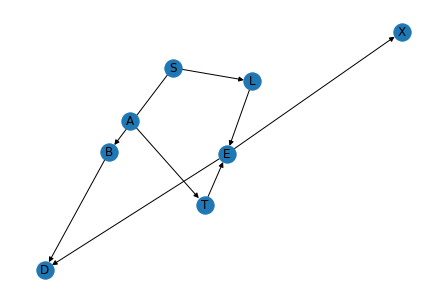

In [126]:
# Ground truth graph
gt_adj = np.zeros([8,8])
gt_adj[0,1] = 1
gt_adj[0,6] = 1
gt_adj[1,4] = 1
gt_adj[2,3] = 1
gt_adj[3,4] = 1
gt_adj[4,5] = 1
gt_adj[4,7] = 1
gt_adj[6,7] = 1

# Create GT in networkx from the adjacency matrix
gt = nx.DiGraph()
for i in range(8):
    for j in range(8):
        if gt_adj[i,j] == 1:
            gt.add_edge(i,j)

# Rename the nodes
gt = nx.relabel_nodes(gt, idx2node)

# Display GT
nx.draw(gt, with_labels=True)

In [ ]:
gt.nodes()

NodeView(('S', 'L', 'B', 'E', 'A', 'T', 'X', 'D'))

In [128]:
for e in gt.edges():
    print(e)

('S', 'L')
('S', 'B')
('L', 'E')
('B', 'D')
('E', 'X')
('E', 'D')
('A', 'T')
('T', 'E')


In [129]:
edges = [('L', 'E'), ('A', 'T'), ('T', 'E'), ('E', 'X'), ('X', 'B'), ('B', 'D'), ('B', 'S')]
best = nx.DiGraph()
for e in edges:
    best.add_edge(e[0], e[1])

In [130]:
for e in best.edges():
    print(e)

('L', 'E')
('E', 'X')
('A', 'T')
('T', 'E')
('X', 'B')
('B', 'D')
('B', 'S')


In [131]:
num_of_correct_edges(gt, best)

0.8571428571428571

# ADULT

In [ ]:
df = pd.read_csv('../data/adult.csv')
# drop rows with missing
df = df.dropna()

In [ ]:
df.head(20)

,Age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [ ]:
# Rename columns
df = df.rename(columns={
    'Age': 'A',
    ' workclass': 'W',
    ' fnlwgt': 'F',
    ' education': 'ED',
    ' education-num': 'EDN',
    ' marital-status': 'M',
    ' occupation': 'O',
    ' relationship': 'R',
    ' race': 'RA',
    ' sex': 'S',
    ' capital-gain': 'CG',
    ' capital-loss': 'CL',
    ' hours-per-week': 'H',
    ' native-country': 'C',
    ' class': 'I'
})

In [ ]:
# Drop the columns F and EDN
df = df.drop(columns=['F', 'EDN'])

In [ ]:
# Discretize the age variable in three groups: <25, 25-60, >60
df['A'] = pd.cut(df['A'], bins=[0, 25, 60, 100], labels=False)

# Discretize the capital gain in two groups: <=5000, >5000
df['CG'] = pd.cut(df['CG'], bins=[-1, 5000, 100000], labels=False)

# Discretize the capital loss in two groups: <=40, >40
df['CL'] = pd.cut(df['CL'], bins=[-1, 40, 100000], labels=False)

# Discretize the hours per week in three groups: <40, 40-60, >60
df['H'] = pd.cut(df['H'], bins=[0, 40, 60, 100], labels=False)


In [ ]:
df.S.value_counts()

 Male      21790
 Female    10771
Name: S, dtype: int64

In [ ]:
# Process the categorical variables
# workclass = {private, non-private}
df['W'] = [1 if x == ' Private' else 0 for x in df['W']]

# education = {high, low}
df['ED'] = [1 if x in [' Bachelors', ' Masters', ' Doctorate', ' Prof-school'] else 0 for x in df['ED']]

# marital-status = {married, non-married}
df['M'] = [1 if x in [' Married-civ-spouse', ' Married-spouse-absent', ' Married-AF-spouse'] else 0 for x in df['M']]

# relationship = {married, non-married}
df['R'] = [1 if x in [' Husband', ' Wife'] else 0 for x in df['R']]

# native-country = {US, non-US}
df['C'] = [1 if x == ' United-States' else 0 for x in df['C']]

# race = {white, non-white}
df['RA'] = [1 if x == ' White' else 0 for x in df['RA']]

# occupation = {office, heavy-work, other}
df['O'] = [1 if x in [' Adm-clerical', ' Sales', ' Exec-managerial', ' Prof-specialty', ' Tech-support'] else 0 for x in df['O']]

# binarize sex variable
df['S'] = [1 if x == ' Male' else 0 for x in df['S']]

# binarize income variable
df['I'] = [1 if x == ' >50K' else 0 for x in df['I']]

In [ ]:
df.head(20)

,A,W,ED,M,O,R,RA,S,CG,CL,H,C,I
0,1,0,1,0,1,0,1,1,0,0,0,1,0
1,1,0,1,1,1,1,1,1,0,0,0,1,0
2,1,1,0,0,0,0,1,1,0,0,0,1,0
3,1,1,0,1,0,1,0,1,0,0,0,1,0
4,1,1,1,1,1,1,0,0,0,0,0,0,0
5,1,1,1,1,1,1,1,0,0,0,0,1,0
6,1,1,0,1,0,0,0,0,0,0,0,0,0
7,1,0,0,1,1,1,1,1,0,0,1,1,1
8,1,1,1,0,1,0,1,0,1,0,1,1,1
9,1,1,1,1,1,1,1,1,1,0,0,1,1


In [ ]:
df.A.value_counts()

1    23818
0     6411
2     2332
Name: A, dtype: int64

In [ ]:
d = df.shape[1]
node2idx = {}
for i, node in enumerate(df.columns):
    node2idx[node] = i

idx2node = {}
for i, node in enumerate(df.columns):
    idx2node[i] = node

idx2node

variables = list(df.columns)

var2num = {}
for var, num in zip(variables, range(d)):
    var2num[var] = num
    
num2var = {value: key for key, value in var2num.items()}

In [ ]:
# Create a random DAG for the adult dataset
variables

['A', 'W', 'ED', 'M', 'O', 'R', 'RA', 'S', 'CG', 'CL', 'H', 'C', 'I']

In [ ]:
len(variables)

13

In [ ]:
G = createPopulation(1, variables, density_factor=0.1, feasible_only=True)[0]

In [ ]:
# Compute BIC score for the random graph
BIC(G, df)

223411.48616671632

In [ ]:
# Create ground truth graph
gt = nx.DiGraph()
gt.add_edges_from([['S', 'O'],
                  ['S', 'H'],
                  ['S', 'R'],
                  ['S', 'ED'],
                  ['S', 'RA'],
                  ['R', 'I'],
                  ['R', 'CL'],
                  ['R', 'CG'],
                  ['R', 'H'],
                  ['R', 'W'],
                  ['R', 'A'],
                  ['R', 'M'],
                  ['R', 'RA'],
                  ['A', 'H'],
                  ['A', 'O'],
                  ['A', 'W'],
                  ['A', 'ED'],
                  ['A', 'M'],
                  ['A', 'C'],
                  ['A', 'RA'],
                  ['A', 'I'],
                  ['H','O'],
                  ['H','W'],
                  ['W', 'O'],
                  ['W', 'ED'],
                  ['W', 'C'],
                  ['O','CL'],
                  ['O','CG'],
                  ['O','I'],
                  ['O','ED'],
                  ['ED','CG'],
                  ['ED','I'],
                  ['ED','RA'],
                  ['ED','C'],
                  ['CG', 'CL'],
                  ['CG', 'I'],
                  ['C','M'],
                  ['C', 'RA'],
                  ['CL', 'I']]
                  )

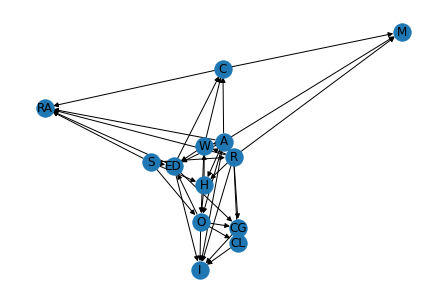

In [ ]:
# Draw the ground truth graph
nx.draw(gt, with_labels=True)


In [ ]:
BIC(gt, df.head(1000))

6662.779506740551